The data is available as two attached CSV files:

takehome_user_engagement. csv
takehome_users . csv

The data has the following two tables:

1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:

    ● name: the user's name

    ● object_id: the user's id

    ● email: email address

    ● creation_source: how their account was created. This takes on one of 5 values:

        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace

        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)

        ○ ORG_INVITE: invited to an organization (as a full member)

        ○ SIGNUP: signed up via the website

        ○ SIGNUP_GOOGLE_AUTH: signed up using GoogleAuthentication (using a Google email account for their login id)

    ● creation_time: when they created their account

    ● last_session_creation_time: unix timestamp of last login

    ● opted_in_to_mailing_list: whether they have opted into receiving marketing emails

    ● enabled_for_marketing_drip: whether they are on the regular marketing email drip

    ● org_id: the organization (group of users) they belong to

    ● invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product. Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [36]:
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1', parse_dates=True)
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [6]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [9]:
# Find number of unique users in user dataframe
users['object_id'].nunique()

12000

In [10]:
# Find number of unique users in engagement dataframe
engagement['user_id'].nunique()

8823

There are 12000 unique users in the user dataset and 8823 unique users in the engagement dataset

## Data Cleaning

In [11]:
# Rename object_id to user_id in users dataframe
users = users.rename(columns={"object_id": "user_id"})

In [12]:
# Convert time_stamp to datetime 
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [13]:
engagement['week'] = engagement['time_stamp'].dt.week
engagement['year'] = engagement['time_stamp'].dt.year
engagement['month'] = engagement['time_stamp'].dt.month
engagement['day'] = engagement['time_stamp'].dt.day

<ipython-input-13-53ece4f6a0d1>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  engagement['week'] = engagement['time_stamp'].dt.week


In [14]:
engagement.head()

,time_stamp,user_id,visited,week,year,month,day
0,2014-04-22 03:53:30,1,1,17,2014,4,22
1,2013-11-15 03:45:04,2,1,46,2013,11,15
2,2013-11-29 03:45:04,2,1,48,2013,11,29
3,2013-12-09 03:45:04,2,1,50,2013,12,9
4,2013-12-25 03:45:04,2,1,52,2013,12,25


In [15]:
# Count visits by week
engagement2 = engagement.groupby(['week','user_id'])['time_stamp'].count().reset_index(name = 'count').drop_duplicates()

In [22]:
# Create adopted column and fill with 1 when count is greater or equal to 3 and 0 if count is less than 3
engagement2['adopted'] = np.nan
engagement2['adopted'] = np.where(engagement2['count'] >= 3, 1, engagement2['adopted'])
engagement2['adopted'] = np.where(engagement2['count'] < 3, 0, engagement2['adopted'])

In [23]:
engagement2.head()

,week,user_id,count,adopted
0,1,2,1,0.0
1,1,10,5,1.0
2,1,42,4,1.0
3,1,43,1,0.0
4,1,46,1,0.0


In [24]:
# Merge datasets based on user_id
df = pd.merge(users, engagement2, on = 'user_id')

In [25]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,week,count,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,17,1,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,0.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,1,0.0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,6,3,1.0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,7,2,0.0


In [27]:
# Count adopter users
df.adopted.value_counts()

1.0    29771
0.0    27401
Name: adopted, dtype: int64

In [28]:
# Drop unnecessary features
df2 = df.drop(['user_id', 'count', 'name', 'email', 'week'], axis = 1)

In [29]:
df2.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
3,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
4,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0


In [30]:
# Set categorical features for label encoding
categorical_features = ['creation_time', 'creation_source']

In [35]:
# Lavel encode categorical features into numerical features
for feature in categorical_features:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(list(df2[feature].values.astype('str')))
    df2[feature] = label_encoder.transform(list(df2[feature].values.astype('str'))) 
    print("for feature {0}: label-encoding was done succesfully".format(feature))

for feature creation_time: label-encoding was done succesfully
for feature creation_source: label-encoding was done succesfully


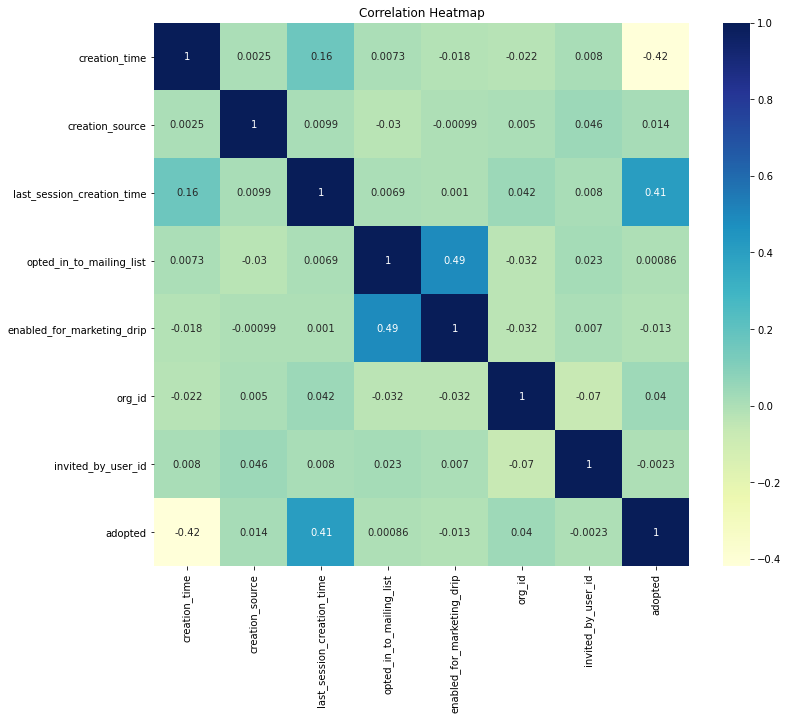

In [38]:
# Plot heatmap correlation
plt.figure(figsize=(12,10))
p=sns.heatmap(df2.corr(), annot=True,cmap ='YlGnBu')
plt.title('Correlation Heatmap');

## Modeling with Pycaret

In [39]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pycaret

In [40]:
from pycaret.classification import *

In [41]:
exp_clf = setup(df2, target = 'adopted', silent=True, session_id=1)

,Description,Value
0,session_id,1
1,Target,adopted
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(57172, 8)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [42]:
get_config('X')

,creation_time,last_session_creation_time,org_id,invited_by_user_id,creation_source_0,creation_source_1,creation_source_2,creation_source_3,creation_source_4,opted_in_to_mailing_list_0,enabled_for_marketing_drip_0
0,7963.0,1.398139e+09,11.0,10803.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5590.0,1.396238e+09,1.0,316.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,5590.0,1.396238e+09,1.0,316.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,5590.0,1.396238e+09,1.0,316.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,5590.0,1.396238e+09,1.0,316.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57167,4721.0,1.378448e+09,89.0,8263.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0
57168,2126.0,1.358275e+09,200.0,5986.220215,0.0,0.0,0.0,0.0,1.0,1.0,1.0
57169,8052.0,1.398603e+09,83.0,8074.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
57170,4.0,1.338638e+09,6.0,5986.220215,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [43]:
# Compare all models in model library
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8040,0.8963,0.8338,0.7983,0.8156,0.6066,0.6073,0.7700
et,Extra Trees Classifier,0.8021,0.8916,0.8198,0.8037,0.8116,0.6032,0.6034,0.3750
dt,Decision Tree Classifier,0.8020,0.8922,0.8198,0.8035,0.8115,0.6030,0.6032,0.0330
rf,Random Forest Classifier,0.8020,0.8926,0.8289,0.7983,0.8133,0.6028,0.6034,0.4670
catboost,CatBoost Classifier,0.8019,0.8961,0.8360,0.7942,0.8145,0.6024,0.6034,6.4030
lightgbm,Light Gradient Boosting Machine,0.8001,0.8940,0.8352,0.7919,0.8129,0.5986,0.5997,0.2910
gbc,Gradient Boosting Classifier,0.7896,0.8802,0.8421,0.7735,0.8063,0.5769,0.5795,0.5160
knn,K Neighbors Classifier,0.7850,0.8617,0.8030,0.7877,0.7953,0.5690,0.5692,0.2770
ada,Ada Boost Classifier,0.7833,0.8729,0.8258,0.7732,0.7985,0.5646,0.5663,0.1700
ridge,Ridge Classifier,0.7781,0.0000,0.8295,0.7641,0.7954,0.5539,0.5562,0.0210


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

In [44]:
# Create xgboost Model
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8068,0.8964,0.8381,0.8001,0.8187,0.6123,0.6130
1,0.8048,0.8977,0.8371,0.7976,0.8169,0.6083,0.6091
2,0.8043,0.9010,0.8227,0.8053,0.8139,0.6077,0.6079
3,0.8043,0.8978,0.8304,0.8007,0.8153,0.6075,0.6079
4,0.7969,0.8945,0.8304,0.7898,0.8096,0.5922,0.5930
5,0.7969,0.8869,0.8424,0.7833,0.8118,0.5918,0.5936
6,0.8018,0.8934,0.8284,0.7981,0.8130,0.6024,0.6029
7,0.8088,0.9013,0.8376,0.8032,0.8200,0.6164,0.6170
8,0.8161,0.9020,0.8376,0.8141,0.8257,0.6312,0.6314
9,0.7989,0.8920,0.8337,0.7908,0.8117,0.5961,0.5971


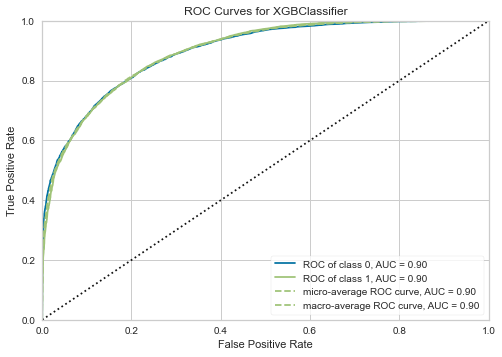

In [45]:
# Plot Model
plot_model(xgboost)

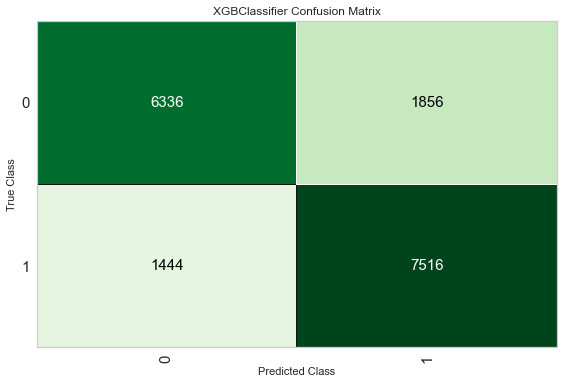

In [46]:
# Plot Confusion Matrix
plot_model(xgboost, plot = 'confusion_matrix')

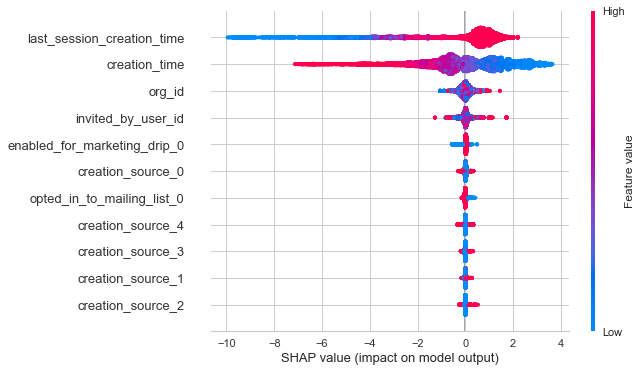

In [50]:
interpret_model(xgboost)

In [47]:
# Evaluate Model
evaluate_model(xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [48]:
#generate predictions on hold-out set using trained model
xgboost_predictions_holdout = predict_model(xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8076,0.8987,0.8388,0.8020,0.8200,0.6136,0.6143


In [49]:
# Finalize model
finalize_model(xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)